# Fraud detection analysis with NN

해당 커널은 캐글의 데이터 셋 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)으로 이상치 감지(Anomaly Dectection)를 한 커널 [Fraud detection analysis with NN](https://www.kaggle.com/mnpathak1/fraud-detection-analysis-with-nn)를 번역한 것입니다.

# 신용 카드 사기 예측

이 분석에서는 거래(Transaction) 데이터에서 신용카드 사기를 예측하는 것이 목표입니다. 사기 데이터는 매우 편향된 데이터입니다. 대부분의 사기 데이터는 하나의 클래스고 나머지는 다른 클래스입니다. 만약 다수로 차지하는 클래스를 예측할 경우, 전체적인 정확도는 매우 높을테지만, 다른 클래스를 완전히 놓치게 될것입니다. 그 다른 클래스가 우리가 예측할 신용카드 사기 거래입니다. 저는 Tensorflow로 예측 모델을 만들것이며, t-SNE로 신용카드 데이터를 2차원으로 시각화하여 살펴볼 것입니다. Reference를 자세히 보시면 이 분석을 이해하는데 도움이 될 것입니다.

이 분석은 다음과 같은 파트로 구성되어 있습니다.

* [데이터 탐색](#1.-데이터-탐색)
* 신경망 구성
    * Tensorflow를 사용한 FC 네트워크
    * Keras를 사용한 FC 네트워크
    * Keras를 사용한 Autoencoder 네트워크: **사기 트랜잭션 감지**
* t-SNE를 사용한 데이터 시각화

### 0. 필요한 패키지 및 데이터 로드

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# from show_confusion_matrix import show_confusion_matrix 
# the above is from http://notmatthancock.github.io/2015/10/28/confusion-matrix.html

In [3]:
df = pd.read_csv("./input/creditcard.csv")

### 1. 데이터 탐색

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

주어진 *creditcard.csv* 데이터 셋에는 거래 시간 Feature(Time), 28 개의 이름없는 Features(V1~V28), 거래 금액(Amount) Feature로 구성되어 있습니다.

한 번 처음 몇 Rows와 각 칼럼들의 기초적인 통계를 보도록 하겠습니다.

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

어떠한 칼럼도 결측치가 없어, 결측치 처리(Imputing Columns) 작업이 필요 없으므로 일이 조금 수월해 졌습니다.

### 타겟 "Class" 칼럼

데이터에서 마지막 칼럼 "Class"는 해당 거래가 사기인지 (=1) 아닌지 (=0) 를 나타냅니다. 이 "Class" 칼럼을 살펴보도록 하겠습니다.

In [8]:
count_classes = pd.DataFrame(pd.value_counts(df['Class'], sort = True).sort_index())
count_classes

,Class
0,284315
1,492


사기 거래는 전체 거래의 492/(492+284315) = 0.1727% 밖에 안됩니다.


### 사기 거래와 보통 거래 vs. time

사기 그리고 일반 거래와 time 칼럼과 비교를 해보겠습니다.

In [9]:
print ("Fraud")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


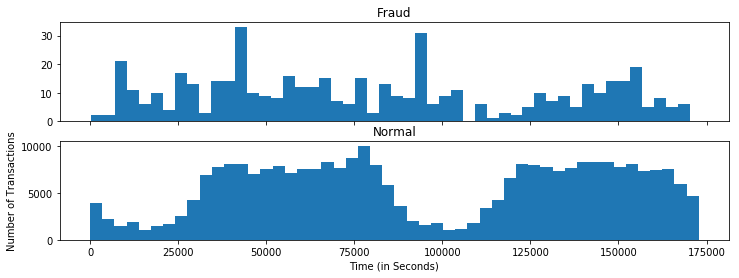

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

**보통 거래들이 순환적으로 분포되어 있는데에 반해, 사기 거래들은 더욱 고르게 분포되어 있습니다.** 보통 거래들은 새벽 시간(1시~5시)대에 훨씬 적은 거래량을 나타내고 있습니다. 이 정보는 한창 거래 될 때가 아닌 시간에 사기 거래가 훨씬 쉽게 감지 되는 것을 보여줍니다.


### 사기 거래와 보통 거래 vs. amount
#### 보통/사기 거래의 임계값(Threshold)

이번엔 거래 금액과 보통/사기 거래 사이의 다른 점을 살펴보도록 하겠습니다.

In [11]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


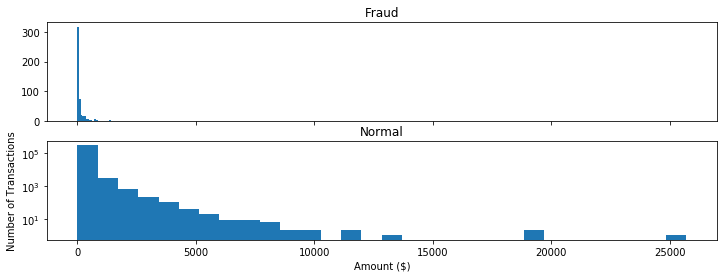

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

대부분의 거래는 100보다 적은 금액이였습니다. **사기 거래는 최대값이 보통 거래의 최대값 보다 훨씬 적었습니다. ( 2,125.87 vs 25,691.16)**

해당 거래 금액이 사기 거래 금의 최대값보다 더 큰지 확인하는 칼럼을 만들어 보겠습니다. 이 칼럼은 사기 거래의 임계치의 역할로 활용됩니다.

In [13]:
df['Amount_max_fraud'] = 1
df.loc[df.Amount <= 2125.87, 'Amount_max_fraud'] = 0
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_max_fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


### Amount vs. time

이번엔, Time과 Amount를 비교해 새로운 것을 발견할 수 있는지 확인해 보겠습니다.

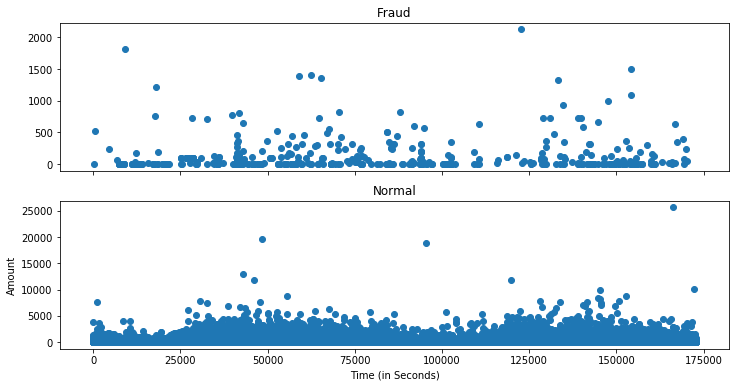

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

사기 거래이든, 보통 거래이든 amount와 time간의 뚜렷한 경향을 찾아볼 수 없습니다.

### 이름없는 Features (V1~V28)

다음으로, 이름없는 Features를 살펴보겠습니다.

In [15]:
#Select only the anonymized features.
v_features = df.iloc[:,1:29].columns

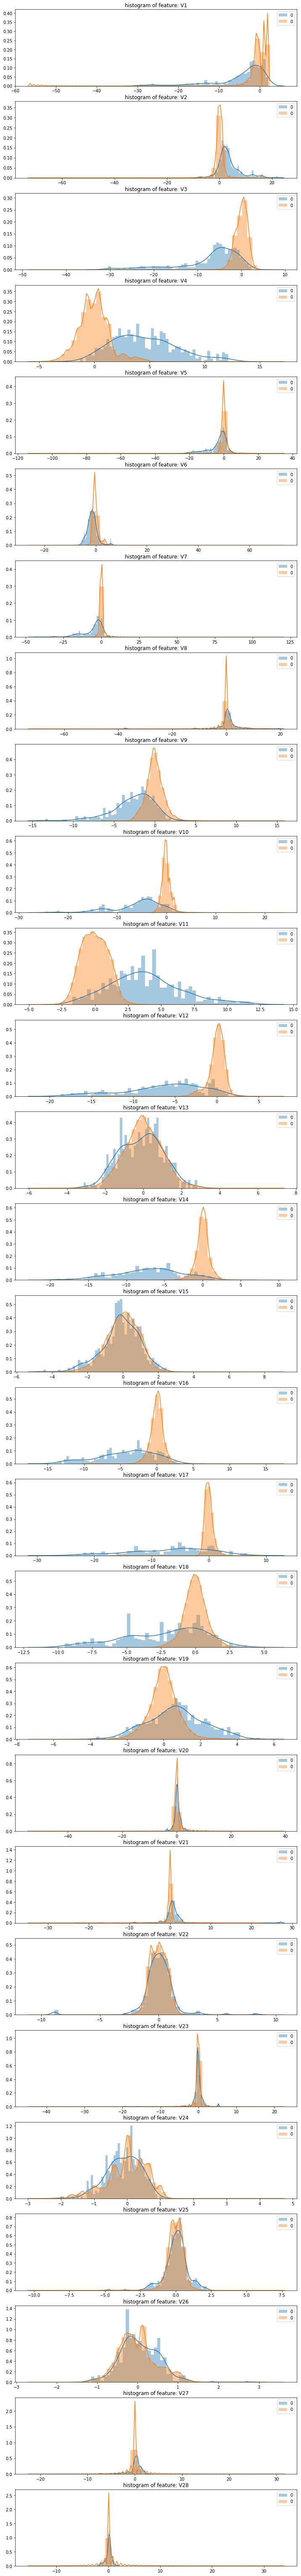

In [16]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    plt.legend(df["Class"])
    ax.set_title('histogram of feature: ' + str(cn))
    
plt.show()

보통(오랜지색) 거래와 사기(파란색) 거래는 각 다른 이름없는 Feature에 대해서 다른 분포를 보입니다. 하지만 어느하나 완전히 분리된 분포를 가진 Feature는 없습니다.

그래서 더 일반적으로 신경망 모델의 정확도에 도움되는 Feature는 없다고 결정짓고, 어떠한 Feature도 제외하지 않기로 결정하였습니다.


### 신경망을 위한 데이터셋 준비

처음엔 "Normal"칼럼을 "Class" 칼럼으로부터 뒤집힌 값이 들어가도록 만듭니다. 이렇게 해서 **하나의 클래스 결과("Class")를 두개("Class", "Normal")로 분리 하였습니다.**

In [17]:
#Create a new feature for normal (non-fraudulent) transactions.
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

그리고 기억하기 쉽도록, **"Class"를 "Fraud"로 칼럼 이름을 변경합니다**.

In [18]:
df = df.rename(columns={'Class': 'Fraud'})

In [19]:
print(df.Normal.value_counts())
print()
print(df.Fraud.value_counts())

1.0    284315
0.0       492
Name: Normal, dtype: int64

0    284315
1       492
Name: Fraud, dtype: int64


더 많은 데이터를 보기 위해 pandas의 [max column](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html) 을 새로 지정합니다.

In [20]:
pd.set_option("display.max_columns",101)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud,Amount_max_fraud,Normal
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,1.0


#### 데이터 셋에서 Training 셋과 Test tpt 분리:

사기 거래와 보통 거래만 각각 있는 데이터 프레임 두개를 생성합니다.

In [21]:
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

사기 데이터 80%와 보통 데이터 80%만 Train 셋으로 사용하도록 Concat 합니다. 나머지 각 데이터 프레임의 20%를 Test 셋으로 만듭니다.

일단 X_train에 80%의 사기 데이터를 지정합니다.

In [22]:
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

그리고 보통 거래 데이터의 80%를 X_train에 추가합니다

In [23]:
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

X_train에 들어있지 않은 나머지 거래 데이터들을 X_test에 넣습니다. 그러면 X_test는 보통/사기 데이터의 나머지 20%의 데이터를 가지게 됩니다.

In [24]:
X_test = df.loc[~df.index.isin(X_train.index)]

연습 겸, 각 만들어진 두 데이터 프레임(X_train, X_test)를 무작위 순서로 섞습니다.

In [25]:
X_train = shuffle(X_train)
X_test = shuffle(X_test)

두 데이터 프레임의 "Fraud"칼럼을 값을 기준으로 각각 카운트하여 보겠습니다.

In [26]:
count_X_train = pd.value_counts(X_train['Fraud'], sort = True).sort_index()
count_X_test = pd.value_counts(X_test['Fraud'], sort = True).sort_index()

print ('Count of normal and fraud on training data: \n', count_X_train)
print ('Count of normal and fraud on testing data: \n', count_X_test)

Count of normal and fraud on training data: 
 0    227452
1       394
Name: Fraud, dtype: int64
Count of normal and fraud on testing data: 
 0    56863
1       98
Name: Fraud, dtype: int64


두 프레임 모두 예상한대로 0과 1의 비율이 똑같이 0.172% 로 나왔습니다.

이제 타겟 Features("Fraud", "Normal")를 y_train, y_test에 넣어 줍니다.

In [27]:
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

타겟 Features를 따로 빼두었으니, 기존 X_train과 X_test에 타겟 Features를 지웁니다.

In [28]:
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

모든 데이터 프레임들이 알맞은 Shape으로 변환이 되었는지 Cross-check를 합니다.

In [29]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(227846, 31)
(227846, 2)
(56961, 31)
(56961, 2)


하지만 해당 데이터의 불균형 때문에, 모델에 좋은 학습을 제공해 주기 위해 같은 비율로 맞춰주어야 합니다. 따라서 모든 데이터 수를 사기 데이터수로 나눠주어 구해진 비율을 구합니다. 이 비율을 데이터 프레임의 "Fraud" 칼럼에 곱해주면 사기 거래수와 보통 거래수가 차지하는 Wieght가 동등하게 됩니다.  
간단하게 보이자면, `ratio = # of normal / # of fraud` 가 됩니다.

In [30]:
ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [31]:
# Fraud가 1이 였던 값에 weight가 가해져 학습을 했을 때 더욱 민감하게 학습이 될 것입니다.
y_train[y_train.Fraud > 1.0].head()

,Fraud,Normal
10484,578.28934,0.0
15539,578.28934,0.0
189701,578.28934,0.0
124036,578.28934,0.0
30473,578.28934,0.0


#### Feature 중앙화 및 스케일링

Train/Test X-데이터셋에서, 각 Feature를 평균 0, 표준편차 1로 변환 시킵니다. 이는 신경망 모델을 학습에 도움을 줍니다.

In [32]:
#Names of all of the features in X_train.
features = X_train.columns.values

for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [33]:
# 모든 Feature가 mean:0, std:1 에 가까워 짐을 확인할 수 있습니다.
X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount_max_fraud
count,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000
mean,-0.000981,0.002513,-0.005920,0.004468,0.003515,0.000882,-0.007049,0.000640,0.003547,-0.003336,0.001112,0.001566,-0.003003,0.002476,-0.001457,0.004771,-0.001298,0.006475,0.002145,-0.003752,0.005089,0.002532,-0.002266,0.000694,0.001255,0.000230,-0.003617,-0.001128,-0.005178,0.000832,-0.000229
std,0.999579,1.002597,1.018439,0.992005,1.001664,0.990564,0.987920,0.975891,0.974153,0.996545,0.986738,0.997945,0.986894,1.006684,0.989983,0.998620,0.993258,0.979525,0.996698,1.007079,0.984642,0.978265,0.996165,0.986243,0.996716,1.004727,1.005400,0.974566,1.028555,1.036437,0.997525
min,-1.996495,-28.798504,-44.035215,-20.513492,-3.653301,-29.290217,-19.636023,-22.807581,-32.877534,-8.630238,-19.239745,-4.026853,-18.062021,-3.867219,-18.829627,-4.797586,-15.182703,-26.943365,-11.081002,-8.523283,-26.675106,-25.326726,-13.089986,-42.838782,-4.660608,-14.379544,-5.401088,-23.266164,-25.520958,-0.353229,-0.046062
25%,-0.848082,-0.472047,-0.362059,-0.583160,-0.597038,-0.502249,-0.579251,-0.448915,-0.174413,-0.591501,-0.492679,-0.747584,-0.413937,-0.658836,-0.444461,-0.635628,-0.536064,-0.567924,-0.593381,-0.570330,-0.275025,-0.310829,-0.748917,-0.256147,-0.581180,-0.608956,-0.679814,-0.174964,-0.161507,-0.330120,-0.046062
50%,-0.216304,0.008638,0.036382,0.115526,-0.010671,-0.040643,-0.207725,0.029786,0.017563,-0.046103,-0.085007,-0.026277,0.135150,-0.013610,0.051565,0.054417,0.069225,-0.071421,-0.008159,0.002786,-0.080291,-0.040014,0.009542,-0.018098,0.070257,0.034972,-0.115678,0.003000,0.032948,-0.265031,-0.046062
75%,0.935563,0.674915,0.484174,0.678346,0.525606,0.438875,0.294860,0.461690,0.274024,0.542844,0.424213,0.726922,0.617056,0.674697,0.513263,0.713854,0.595188,0.469295,0.599208,0.564558,0.175128,0.251457,0.726915,0.239267,0.721670,0.674138,0.495060,0.225670,0.235973,-0.045537,-0.046062
max,1.642055,1.253349,10.121300,2.690291,11.918722,25.214090,17.952680,35.611260,16.751505,9.459845,14.001643,11.000614,4.409860,4.590704,7.546716,6.319690,6.528161,10.052776,5.622204,6.422705,49.443471,37.034649,9.357086,36.076612,6.601689,10.599127,7.181774,30.107589,102.543241,75.250448,21.709793


마지막으로 Validation을 위해 Test 셋에서 반을 Validation으로, 반을 Test로 사용합니다.

*(어짜피 Label은 모두 존재하기 때문에 Test셋 에서 나누든 Train셋에서 나누든 상관 없습니다.)*

In [34]:
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [35]:
print(np.shape(inputX))
print(np.shape(inputY))
print(np.shape(inputX_valid))
print(np.shape(inputY_valid))
print(np.shape(inputX_test))
print(np.shape(inputY_test))

(227846, 31)
(227846, 2)
(28480, 31)
(28480, 2)
(28481, 31)
(28481, 2)


## 2.1 Tensorflow 신경망 학습

완전히 연결된 신경망은 해당 모델을 구성하고 예측하는 이 분석을 위해 아래와 같이 구성되어 있습니다.

* Input Node는 Input 칼럼 숫자 31개로 구성되어 있습니다.
* 5층 신경망으루 구성되어 있고 마지막 레이어는 Output 레이어입니다. 모든 레이어는 Sigmoid로 활성화를 합니다
* 첫 레이어는 18 개의 노드로 구성되어 있고, 다음 층으로 갈수록 노드의 수가 1.5배 됩니다.
* pkeep은 dropout 지켜야하는 노드의 비율(%)을 의미합니다. (ropout은 NN의 Accuracy를 올려줍니다.)
* 다른 하이퍼파라미터 (epochs, batch size, learning rate)도 선언되어 있습니다.
* Cost는 [reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum)을 사용합니다.
* Cost를 최소화하기 위해 [AdamOptimized](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) 를 사용합니다.
* [예측 점수](https://www.tensorflow.org/api_docs/python/tf/equal), 정확도 점수를 정의하고, 가장 좋은 Weights를 저장합니다.
* Test 데이터 셋에 가장 좋은 예측 결과를 가진 Weights를 적용합니다.

이런식으로 Tensorflow session을 하나 만들어 해당 신경망을 Training 셋으로 학습시키고 Validation 셋으로 테스트해볼 수 있습니다.

In [36]:
# Number of input nodes.
input_nodes = 31

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

In [37]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

In [38]:
# Parameters
training_epochs = 101 # should be larger number
training_dropout = 0.9
display_step = 5 # 10 
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

In [39]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping


# Save the best weights so that they can be used to make the final predictions
save_flag = True
saver = tf.train.Saver()
model_path_name = './model/model.ckpt'


# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, y_: batch_y, pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, y_: inputY, pkeep: training_dropout})
            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
    
            # save not overfit & best accuracy model
            '''
            if newCost < valid_newCost and save_flag:
                save_flag = False
                save_path = saver.save(sess, "model_not_overfitted")
                print("The save path not overfitted :", save_path)
            '''
    print()
    print("Optimization Finished!")
    print()
    
    save_path = saver.save(sess, model_path_name)
    print("save path :", save_path)

Epoch: 0 Acc = 0.96798 Cost = 69768.75781 Valid_Acc = 0.96896 Valid_Cost =  6496.27637
Epoch: 5 Acc = 0.97706 Cost = 55160.21875 Valid_Acc = 0.97756 Valid_Cost =  6001.99268
Epoch: 10 Acc = 0.97528 Cost = 47303.35156 Valid_Acc = 0.97626 Valid_Cost =  6052.61523
Epoch: 15 Acc = 0.96992 Cost = 42592.11719 Valid_Acc = 0.96984 Valid_Cost =  6556.98730
Epoch: 20 Acc = 0.97315 Cost = 34016.53125 Valid_Acc = 0.97324 Valid_Cost =  7744.64990
Epoch: 25 Acc = 0.96592 Cost = 29393.52344 Valid_Acc = 0.96429 Valid_Cost =  10923.19238
Epoch: 30 Acc = 0.96947 Cost = 25339.57617 Valid_Acc = 0.96928 Valid_Cost =  14446.64453
Epoch: 35 Acc = 0.98453 Cost = 15805.66797 Valid_Acc = 0.98473 Valid_Cost =  18466.99609
Epoch: 40 Acc = 0.99003 Cost = 10293.99219 Valid_Acc = 0.98975 Valid_Cost =  23956.53125
Epoch: 45 Acc = 0.99058 Cost = 8710.39062 Valid_Acc = 0.99066 Valid_Cost =  26466.08008
Epoch: 50 Acc = 0.98655 Cost = 10369.94531 Valid_Acc = 0.98613 Valid_Cost =  27938.96680
Epoch: 55 Acc = 0.99605 Cost 

#### 정확도와 Cost 요약

epoch에 따른 cost와 정확도를 시각화해 보겠습니다. 이를 통해 Training 셋과 Validation 셋에 대해 어떻게 정확도가 향상할 수 있는지 보실 수 있습니다.

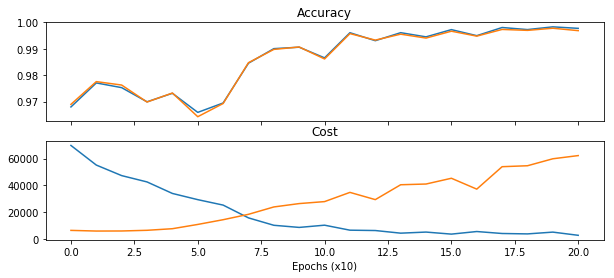

In [41]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # orange
ax1.set_title('Accuracy')


ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

Training 과 Validation 정확도가 같이 거의 100%에 가까운 정확도로 향하는 것을 보실 수 있습니다. Training Cost는 100 epoch이후에 줄어들 기미가 안보입니다. Validation Cost는 70 epoch 부근에서 Training Cost와 비슷함을 보여준다. 그리고 70 세대 이후에는 Training 셋에 Overfitting 됨을 확인할 수 있습니다.

#### Test 셋 예측 및 정확도

In [42]:
predicted = tf.argmax(y, 1)
with tf.Session() as sess:  
    # Load the best weights
    saver.restore(sess, model_path_name)
    testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                     feed_dict={x: inputX_test, y_:inputY_test, pkeep: 1})
    print("Testing Accuracy =", testing_accuracy)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Testing Accuracy = 0.997156


최종 저장되었던 모델을 불러와 **Test 셋으로 99% 정도의 정확도를 얻을 수 있습니다.**

## 2.2 Keras 신경망 학습

아래의 코드는 원본 데이터와 EDA 이해를 바탕으로 Keras를 사용한 신경망(NN)입니다. Keras는 Tensorflow로 구성된 High Level 프레임워크입니다. (Higl Level 프레임워크는 코드를 간결하게 만들어, 코드 이해를 쉽게 만듭니다.) Keras로 신경망(NN) 모델의 정확도를 계산해 보겠습니다.

In [43]:
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [44]:
data = pd.read_csv("./input/creditcard.csv")

In [45]:
#data['Normal']=1-data['Class'], instead I am converting Class to categorical
data['Amount_max_fraud'] = 1
data.loc[data.Amount <= 2125.87, 'Amount_max_fraud'] = 0
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_max_fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


Train-Test 데이터를 나눌 때, 사기/보통 거래의 비율을 같게하기 위해 **Class 칼럼을 계층화(Stratify)**합니다. 여기에선 Validation 셋을 쓰지 않겠습니다.

In [46]:
train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Class'])# stratify the Class

In [47]:
count_train = pd.value_counts(train['Class'], sort = True).sort_index()
count_test = pd.value_counts(test['Class'], sort = True).sort_index()
print(count_train) 
print(count_test)

0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


In [48]:
print(count_train[1] / (count_train[0] + count_train[1])) # Fraud/Nomal Ratio
print(count_test[1] / (count_test[0] + count_test[1])) # Fraud/Nomal Ratio

0.001729245759178389
0.0017204452090867595


타겟 칼럼(Class)를 입력 데이터셋에서 삭제(Drop)합니다.

In [49]:
X_train = train.drop(['Class'], axis = 1)
X_test = test.drop(['Class'], axis = 1)

In [50]:
X_train.head(n=10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount_max_fraud
36001,38355.0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,0.499167,-0.572665,0.346009,-0.047407,-0.098964,-0.663284,0.181411,-0.124345,-0.790453,-0.720944,-0.084556,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.67,0
12844,22555.0,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,-0.658751,1.281502,-1.430087,0.372028,1.403024,-2.739413,-1.331766,1.964590,-0.205639,1.325588,-0.373759,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086,16.94,0
2873,2431.0,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,-1.109522,-1.016020,-0.654945,-1.473470,0.317345,1.067491,-0.372642,-0.674725,0.369841,0.095583,-0.039868,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.00,0
145263,86773.0,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,0.154307,0.882673,0.547890,0.269484,-1.253302,-0.883963,0.495221,-0.153212,0.296710,0.136148,0.382305,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.78,0
186658,127202.0,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,0.428729,1.136666,0.273476,0.697123,-1.222134,-0.938820,1.298149,0.912921,-0.793721,1.064984,0.106592,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.96,0
34271,37590.0,-6.341667,1.192815,-3.686579,-2.754006,-5.007164,3.988118,1.693606,-13.577522,2.557965,-0.931438,-1.189333,0.762725,-0.517857,0.067279,-0.099498,0.837768,-0.156679,-0.402600,-0.238742,-7.171342,9.779321,-3.660198,-1.507217,-0.179185,0.002092,-0.019168,3.611243,-0.894494,1437.08,0
76782,56739.0,-0.463928,0.204745,2.795734,1.546200,-0.720374,1.108212,-0.581133,0.544075,1.099843,-0.653523,-1.420838,0.427211,-0.436201,-1.055012,-1.225903,-1.179268,0.846734,-0.374502,0.623190,-0.052393,0.094431,0.788161,-0.100344,0.126248,-0.461584,-0.200985,0.280168,0.180046,11.10,0
1169,912.0,-1.394619,0.554224,-0.617805,-0.313706,2.157413,3.537534,-0.567305,1.380888,-0.112291,0.107269,-0.637728,0.099510,-0.062533,0.254824,0.318805,-0.335245,0.052870,0.048783,1.654699,0.336595,-0.196300,-0.546172,-0.124758,1.046780,-0.089474,0.363674,0.215692,0.225698,24.08,0
282674,171058.0,-2.121785,-1.518485,2.667942,-2.458839,-1.414952,0.807935,-1.870160,0.516477,-0.553359,0.645799,-0.514941,0.618199,1.461221,-2.116306,-3.244732,-0.345286,0.368870,0.699637,0.031145,-0.684797,-0.079591,0.659885,-1.000976,-0.212991,0.420722,-0.019645,-0.482792,-0.407780,28.00,0
130872,79450.0,-2.254788,-0.955967,0.590596,0.114744,-5.876531,3.364858,6.365904,-1.252960,0.243849,-1.637022,-0.626434,0.105457,0.859541,-1.306715,-0.724693,0.553933,-0.590110,-0.471491,-0.291435,-0.772127,-0.601908,-0.092918,0.517855,0.534361,0.494493,0.301414,0.507071,-0.560888,1354.98,0


그리고 타겟을 정의합니다.

In [51]:
Y_train = train.loc[:, ['Class']]
Y_test = test.loc[:, ['Class']]

In [52]:
# Just sanity check
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(227845, 31)
(227845, 1)
(56962, 31)
(56962, 1)


이번엔 Y_train과 Y_Test를 2개의 클래스를 가지는 Categorical Values로 변환합니다.

In [53]:
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [54]:
np.unique(Y_train, axis=0)

array([[0., 1.],
       [1., 0.]], dtype=float32)

입력 데이터셋에 정규화(Centering and Scaling)를 적용합니다.

In [55]:
#Names of all of the features in X_train.
features = X_train.columns.values

for feature in features:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [56]:
X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount_max_fraud
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,0.005139,0.006783,0.004003,-0.002811,0.001057,-0.002541,-0.002311,0.000114,-0.005443,0.001423,0.002917,-0.008161,-0.000041,-0.000321,-0.003872,0.003222,-0.001978,0.000035,0.003967,0.000940,-0.003482,-0.003067,-0.006804,0.006418,-0.001680,-0.001673,0.009358,0.003430,-0.006029,-0.002762,-0.005195
std,0.998959,0.991084,0.975726,1.000395,1.002287,1.037301,1.020548,1.052306,1.005681,1.004602,1.005792,0.995285,0.998488,0.999305,0.995902,0.996960,1.002095,0.991084,0.997565,1.006987,0.991601,1.001834,1.006337,0.995456,0.997595,0.999471,0.999232,1.032498,0.986538,1.031676,0.942043
min,-1.996537,-18.640252,-28.722479,-31.871677,-3.927001,-82.407952,-15.052954,-22.807581,-34.734141,-8.630238,-19.239745,-3.927948,-18.568526,-3.867219,-20.044245,-4.470963,-14.449819,-25.561333,-10.569916,-5.674207,-70.691337,-29.434190,-11.841840,-52.571789,-4.660608,-16.683278,-3.687188,-21.996904,-46.746035,-0.353229,-0.046062
25%,-0.853426,-0.463875,-0.363474,-0.589585,-0.598655,-0.502851,-0.578069,-0.445477,-0.176824,-0.584429,-0.491456,-0.752641,-0.406027,-0.651183,-0.442192,-0.629025,-0.538465,-0.570989,-0.590404,-0.559835,-0.274473,-0.313414,-0.756551,-0.256508,-0.588789,-0.605699,-0.669323,-0.173930,-0.158599,-0.330780,-0.046062
50%,-0.201890,0.018508,0.037449,0.112718,-0.015604,-0.037550,-0.209371,0.031651,0.016664,-0.047884,-0.087869,-0.042653,0.140433,-0.013747,0.048731,0.056303,0.075434,-0.078295,-0.006511,0.004373,-0.080084,-0.044081,-0.000454,-0.014947,0.066119,0.034672,-0.099246,0.003594,0.034397,-0.265671,-0.046062
75%,0.935415,0.673778,0.485168,0.670664,0.521721,0.445901,0.294835,0.460571,0.272035,0.545800,0.416090,0.713728,0.617349,0.671185,0.508547,0.708872,0.594398,0.474034,0.599056,0.563700,0.170239,0.251604,0.722727,0.240184,0.722627,0.669307,0.508652,0.224801,0.234739,-0.043378,-0.046062
max,1.641907,1.249048,11.446954,2.628480,10.809043,21.022418,55.020053,97.478068,15.307174,9.439610,13.992774,11.775017,4.850326,7.160723,7.742518,9.699100,19.760405,9.105285,4.883746,6.869402,25.613973,30.788496,9.357086,33.314118,7.569671,14.425293,7.293962,78.319259,68.528383,102.362063,21.709793


그리고 Kearas 모델을 구축합니다.

In [57]:
# fix random seed for reproducibility
np.random.seed(2)

5 층 네트워크로 마지막은 결과 레이어로 구성하였습니다. 첫 레이어는 Input Dimension을 X_train 칼럼 수인 31로 하였습니다. 마지막 레이어는 softmax 활성화를 사용하였고 나머지는 relu로 활성화하였습니다. 모든 레이어는 0.9인 dropout을 적용합니다. (각 층의 90%의 정보만 사용한다는 뜻입니다.)

In [58]:
model = Sequential()
model.add(Dense(64, input_dim=31, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(2, activation='softmax'))  # With 2 outputs

loss는 binary cross-entropy로, optimizer는 adam으로 모델을 학습할 수 있도록 설정(compile)합니다. 평가기준(metrics)은 정확도(accuracy)로 받습니다.

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

컴파일된 모델을 Training 데이터로 학습(Fit)합니다. 일단 batch_size 2048로 두고 10 epoch(세대)만 학습합니다.

In [60]:
epoch = 10
batch_size = 2048
model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size)

Epoch 1/10
227845/227845 [==============================] - 1s 6us/step - loss: 0.9423 - acc: 0.8743
Epoch 2/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.1413 - acc: 0.9813
Epoch 3/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0819 - acc: 0.9913
Epoch 4/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0606 - acc: 0.9948
Epoch 5/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0502 - acc: 0.9960
Epoch 6/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0449 - acc: 0.9969
Epoch 7/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0401 - acc: 0.9973
Epoch 8/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0376 - acc: 0.9976
Epoch 9/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0360 - acc: 0.9978
Epoch 10/10
227845/227845 [==============================] - 1s 3us/step - loss: 0.0347 - a

In [61]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

56962/56962 [==============================] - 2s 40us/step
Test score: 0.027565599375151788
Test accuracy: 0.9982795547909132


**99.82%의 정확도를 Test에서 얻을 수 있습니다!** 이걸로 충분할까요? 10 epoch 이상으로 적용하면 아마 더 도움이 될 것입니다.

### Training과 Testing, 그리고 loss vs epoch:

일단 모델을 다시 실행하여 Train과 Test의 정확도와 epoch에 따른 loss를 살펴보도록 하겠습니다.

In [62]:
history = model.fit(X_train, Y_train, batch_size = 2048, epochs = 20, 
         validation_data = (X_test, Y_test), verbose = 2)

Train on 227845 samples, validate on 56962 samples
Epoch 1/20
 - 1s - loss: 0.0332 - acc: 0.9980 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 2/20
 - 1s - loss: 0.0326 - acc: 0.9980 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 3/20
 - 1s - loss: 0.0322 - acc: 0.9981 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 4/20
 - 1s - loss: 0.0318 - acc: 0.9981 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 5/20
 - 1s - loss: 0.0309 - acc: 0.9981 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 6/20
 - 1s - loss: 0.0308 - acc: 0.9981 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 7/20
 - 1s - loss: 0.0305 - acc: 0.9982 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 8/20
 - 1s - loss: 0.0297 - acc: 0.9982 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 9/20
 - 1s - loss: 0.0296 - acc: 0.9982 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 10/20
 - 1s - loss: 0.0298 - acc: 0.9982 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 11/20
 - 1s - loss: 0.0287 - acc: 0.9982 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 12/20
 - 1s - loss: 0.0293 -

In [63]:
# Check the history keys
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

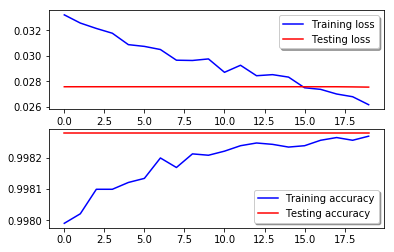

In [64]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

작은 epoch내에서 Test 데이터셋의 정확도의 변화를 잘 보이지 않음을 알 수 있습니다.

### Confusion matrix

이번엔 2 클래스에 대한 Confusion Matrix를 보도록 하겠습니다.  
Confusion matrix를 얻기위해 아래와 같은 함수를 사용하도록 하겠습니다.

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

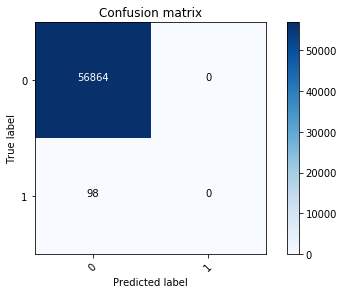

In [66]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
plt.show()

기본적으로 **이 모델은 사기 거래를 정확히 예측 못하고 있었습니다.** 그래도 적어도, 보통 거래를 사기라고 예측하진 않았습니다.

## 2.3 Keras Autoencoder 신경망

저흰 앞의 기본적인 신경망을 통해 심하게 편향된 사기 데이터 (< 0.2%)를 잡을 수 없다는 것을 알았습니다. 그래 이 문제를 소위 인풋을 예측하기위해 만들어진 **Autoencoder 네트워크**를 케라스로 구성하여 이 문제를 다시 바라보기로 하였습니다. 예를 들어, f(x) = x를 모델로 가지기 위해 Weights 와 Biases를 최적화 한다고 해보면, NN에서는 어떻게 할까요? input, output 층이 같아질 때 까지 중간에서 네트워크를 계속 짜낼 것입니다. Autoencoder의 loss와 error는 이러한 학습과정을 최소화 할 수 있도록 재구축 되었습니다.

패키지들을 재로딩 해보겠습니다.

In [67]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [68]:
# Reload data and then drop time column and standardize Amount column
# Also we follow the already done analysis on this dataset
df = pd.read_csv("./input/creditcard.csv")
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Autoencoder를 학습하는 것은 기존에 하던 것과는 조금 다릅니다. 일단 여기선 따로 사기(Fraud)인 거래와 보통(Normal) 거래를 따로 구분짓지 않습니다. 보통(Normal) 거래로만 모델을 학습 시키겠습니다. (아래 X_train 코드를 봐보세요!)

In [69]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

아래에 Autoencoder 모델을 구성하였습니다. 4 FC 층으로 input layer는 14, 7, 7, 29 뉴런으로 구성되어 있습니다. 처음 두 Layer는 Encoder(압축용)이고 마지막 두 Layer는 Decoder(해제용) 입니다. Input과 Output Layer는 같은 수의 뉴런을 가집니다. L1 regularization (Overfitting 방지를 위해) 을 적용합니다. 이런 비슷한 포맷으로 다른 네트워크도 형성할 수 있습니다.

In [70]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

이 Autoencoder 모델을 Compile하고, batch가 1000인 10 epoch의 기록들을 수집합니다.

In [71]:
nb_epoch = 10
batch_size = 1000

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, 
                          validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 1s 6us/step - loss: 1.5176 - acc: 0.1459 - val_loss: 1.2206 - val_acc: 0.2074
Epoch 2/10
227451/227451 [==============================] - 1s 5us/step - loss: 1.0685 - acc: 0.2265 - val_loss: 1.0416 - val_acc: 0.2707
Epoch 3/10
227451/227451 [==============================] - 1s 5us/step - loss: 0.9830 - acc: 0.2880 - val_loss: 0.9903 - val_acc: 0.3025
Epoch 4/10
227451/227451 [==============================] - 1s 5us/step - loss: 0.9440 - acc: 0.3048 - val_loss: 0.9625 - val_acc: 0.3080
Epoch 5/10
227451/227451 [==============================] - 1s 5us/step - loss: 0.9232 - acc: 0.3085 - val_loss: 0.9468 - val_acc: 0.3102
Epoch 6/10
227451/227451 [==============================] - 1s 5us/step - loss: 0.9100 - acc: 0.3119 - val_loss: 0.9367 - val_acc: 0.3134
Epoch 7/10
227451/227451 [==============================] - 1s 5us/step - loss: 0.8998 - acc: 0.3156 - val_loss: 0.9275 -

이 모델은 케라스의 ModelCheckpoint를 통해 model.h5의 형태로 저장되었습니다. 그래서 우리가 원할때 해당 모델을 로딩할 수 있게 되었습니다. 이제 모델의 loss와 accuracy를 training과 validation할 동안 history 된 것을 기반으로 보도록 하겠습니다.

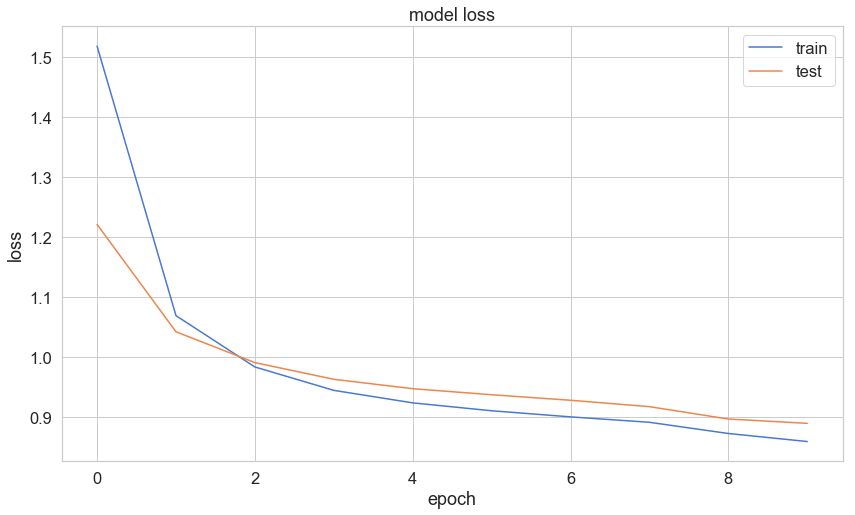

In [72]:
# Plot model loss vs. epoch

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

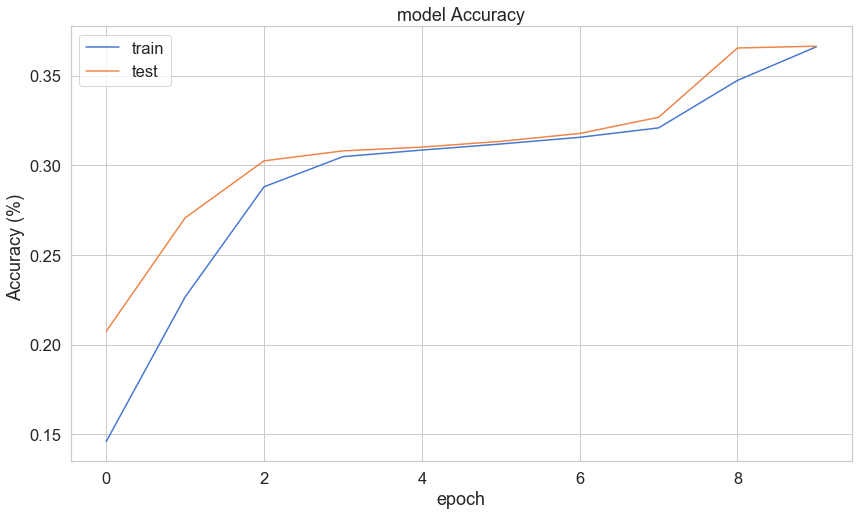

In [73]:
# Plot model Accuracy vs. epoch

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model Accuracy')
plt.ylabel('Accuracy (%) ')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Autoencoder를 이용한 예측과 error 재구성

한번 위의 모델 기반으로 X_test를 예측해보도록 하겠습니다. 그리고 여기서 재구성된 (mean squared) error를 살펴보도록 하겠습니다.

In [74]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.871004,0.001720
std,3.568457,0.041443
min,0.089433,0.000000
25%,0.330827,0.000000
50%,0.502962,0.000000
75%,0.744535,0.000000
max,254.158931,1.000000


* 클래스가 0 이든 1 이든, 재구성된 error는 매우 넓은 범위를 가집니다. 이 error의 분포를 보통(Normal) 클래스와 사기(Fraud) 클래스로 나누어 살표 보도록 하겠습니다.

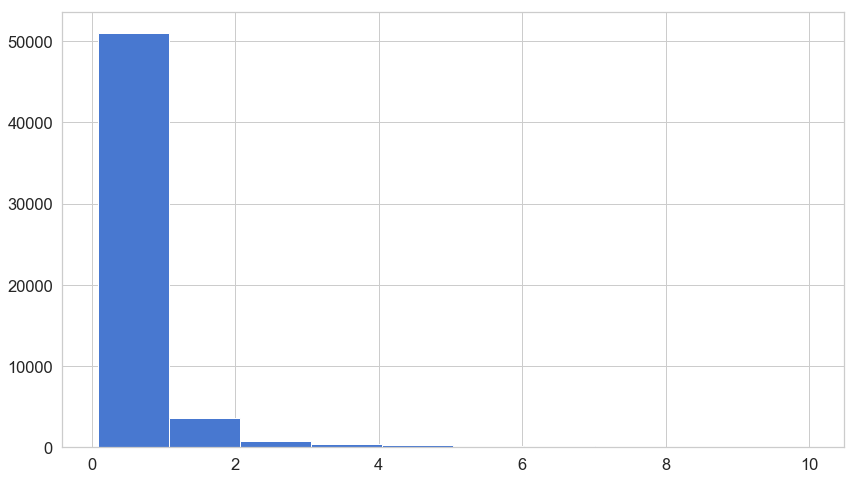

In [75]:
# Reconstruction error in normal class

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

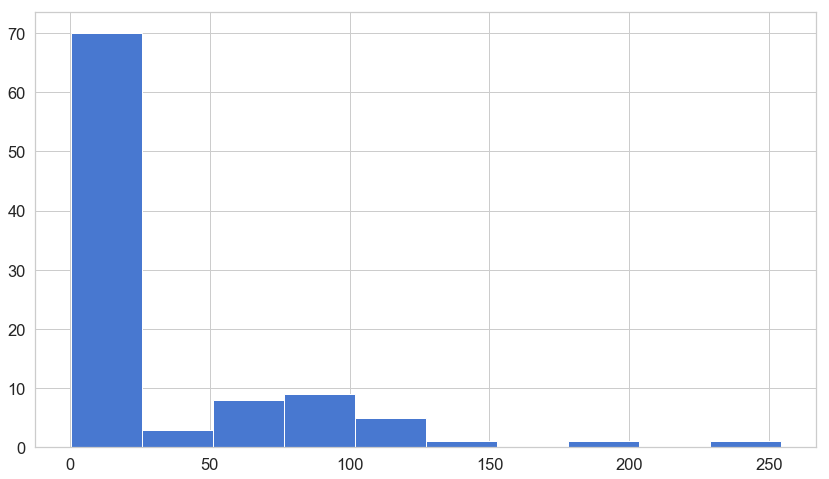

In [76]:
# Reconstruction error in Fraud class

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

우린 재구성된 에러가 사기(Fraud) 클래스에서 넓은 꼬리를 가진다는 것을 볼 수 있습니다.

## Autoencoder의 Confusion Matrix

거래의 클래스를 예측하기 위해선, 해당 거래의 재구성된 에러를 추정해야합니다. **만약 예측된 에러가 threshold(임계값)보다 커진다면,** 이것은 사기(Fraud)라고 판단하고, 나머지는 보통(Normal) 거래로 판단합니다.

In [77]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

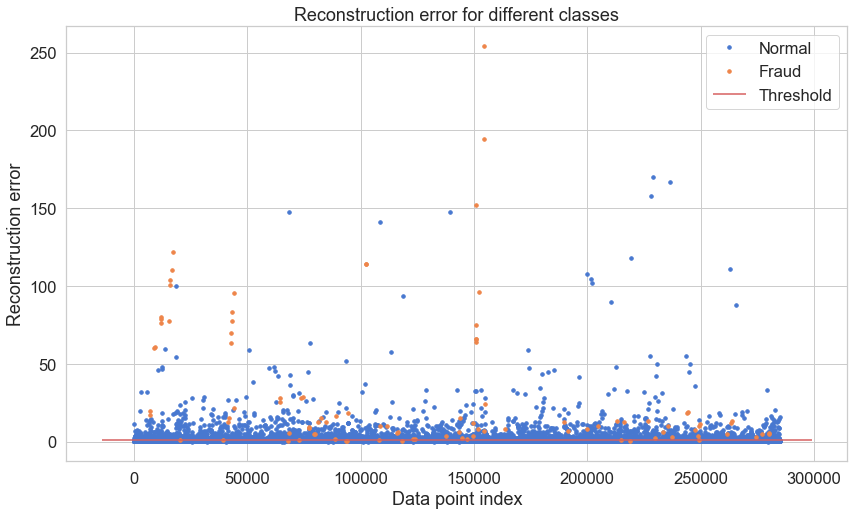

In [78]:
# Prediction with a threshold

threshold = 1

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

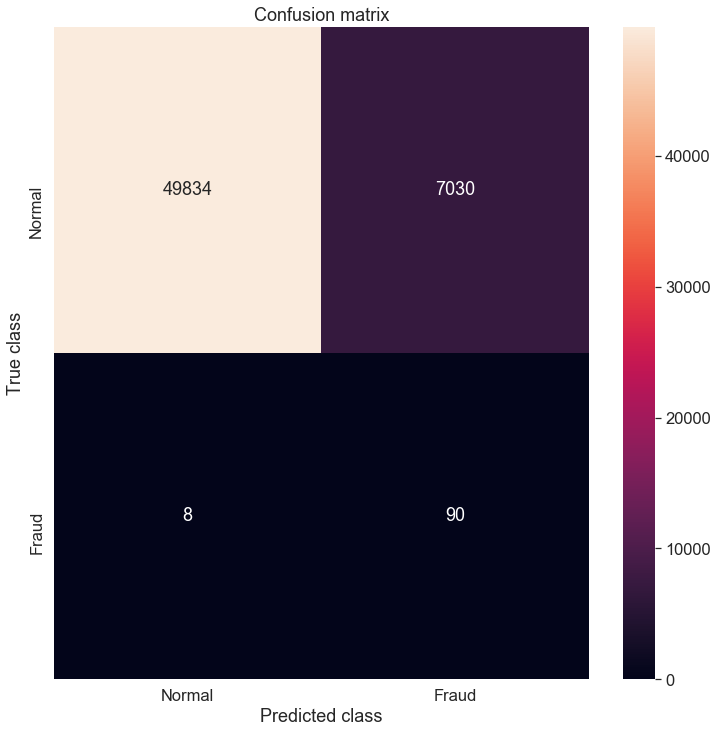

In [79]:
# Confusion matrix

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Autoencoder 모델은 Fraud 거래를 매우 편향된 데이터 속에서도 탐지할 수 있습니다.**  
하지만 사기거래를 대부분 잡더라도, 보통(Normal) 거래도 사기로 12% 정도나 판단합니다! 더 큰 임계값(threshold)는 miss 분류를 줄일 수는 있겠으나, 사기 클래스의 탐지 정확도를 떨어트리게 됩니다.

## 3. t-SNE로 데이터 시각화

**t-Distributed Stochastic Neighbor Embedding (t-분포 확률적 이웃 임베딩, t-SNE) [wiki page](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)** 은 차원 축소 기술 중 하나입니다. 특히 높은 차원의 데이터를 시각화에 알맞도록(2, 3차원) 차원축소를 합니다. t-SNE는 Geoffrey Hinton 과 Laurens van der Maaten 이 개발하였습니다.

원본데이터를 다 사용하면 시간이 너무 많이 걸리기 때문에, 원본 데이터를 t-SNE를 위해 조금 샘플링 하도록 하겠습니다. 만약 t-SNE를 통한 산포도를 통해 사기 거래와 보통 거래를 확연히 대조된다면, 신경망과 특성공학을 통해 이 예측을 더 좋게 동작할 수 있을 것입니다.

In [80]:
#reload the original dataset
tsne_data = pd.read_csv("./input/creditcard.csv")

In [81]:
#Set df2 equal to all of the fraulent and 10,000 normal transactions.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)

In [82]:
#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.iloc[:,-1].values

In [83]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

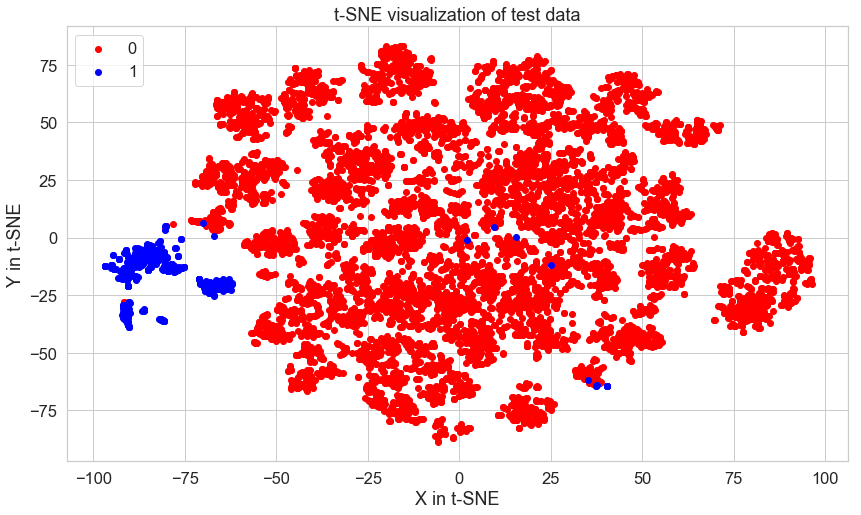

In [84]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

대부분의 사기 거래들은 t-SNE 산점도에서 보시는 바와 같이 조금 섞여 있긴하지만 잘 분리되어 있습니다. 이 시각화는 전체 데이터를 완전히 대표하는게 아니고 샘플마다 다르게 나타날 수 있습니다. 지금, 우리가 분석에 사용했던 Training 셋을 t-SNE를 통해 살펴보도록 하겠습니다. 아마 위와 같이 분리가 잘되는 것을 볼 수 있을 것입니다.

In [85]:
#Set df_used to the fraudulent transactions' dataset.
df_used = Fraud

#Add 10,000 normal transactions to df_used.
df_used = pd.concat([df_used, Normal.sample(n = 10000)], axis = 0)

In [86]:
#Scale features to improve the training ability of TSNE.
df_used_std = standard_scaler.fit_transform(df_used)

#Set y_used equal to the target values.
y_used = df_used.iloc[:,-1].values

In [87]:
x_test_2d_used = tsne.fit_transform(df_used_std)

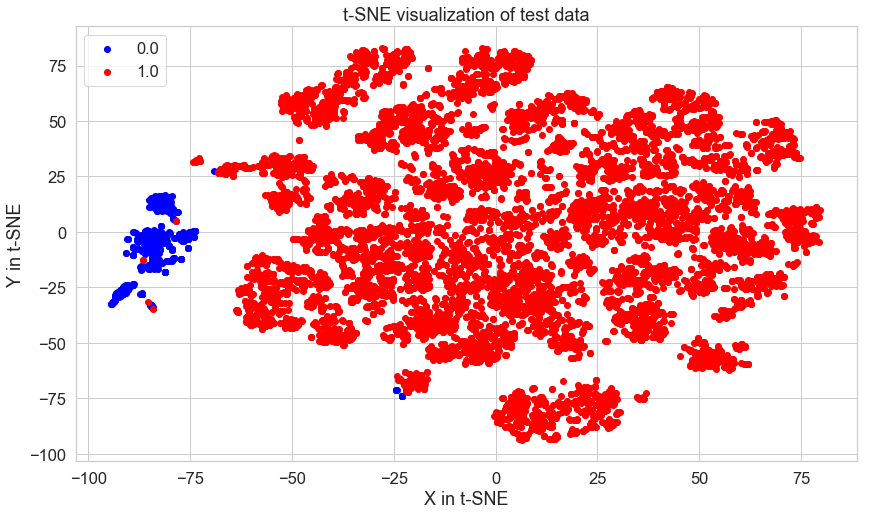

In [88]:
color_map = {1:'red', 0:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y_used)):
    plt.scatter(x=x_test_2d_used[y_used==cl,0], 
                y=x_test_2d_used[y_used==cl,1], 
                c=color_map[idx], 
                label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

여기에서 봤듯이 대부분 보통 거래들과 잘 분리됨을 볼 수 있습니다. 이는 우리가 특성 공학을 기반으로한 모델의 성능을 좋게 할 수 있음을 나타냅니다.

### 결론

* EDA로 사기 거래와 보통 거래는 어떤 파라미터에서도 확연히 나눠지는 것을 볼 수 없었습니다.

* 사기 거래들은 매우 적었습니다. 다르게 말하면, 사기 거래의 최대 값보다 큰 거래들은 보통 거래라 판단할 수 있었습니다.

* Tensorflow와 Keras로 만든 모델(FC)들은 매우 높은 정확도(99.46%, 99.82%)를 볼 수 있었습니다. 하지만, 매우 편향된 데이터라 사기 거래를 탐지하진 못했습니다.

* 새로 재편성한 error계산 법으로 생성된 작은 임계값(threshold)를 가지는 Autoencoder 모델은 대부분의 사기 거래를 탐지할 수 있었습니다. 그러나, 보통거래를 상당히 사기거래로 잘못 탐지하였습니다.

* t-SNE 산점도는 보통 거래와 사기데이터를 시각적으로 잘 구분됨을 보여주었습니다. 이는 특성 공학을 잘 하게 된다면 좋은 정확도를 가지는 모델을 만들 수 있다는 것을 보여주었습니다.


### 어떻게 사기 탐지 정확도를 향상시킬 수 있을까?

* 물론, 데이터가 많은게 좋습니다. (특히 NN에서)

* 더 큰 Autoencoder NN을 학습 시킵니다. (혹시 다른 방법이 있을까요?)


### Reference:

* [tensoflow Kaggle notebook by Currie32](https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow) 는 Tensorflow로 개발된 이 분석을 하는 것을 도와줍니다. 이를 제공해 주셔서 감사합니다.
* [Keras model](https://keras.io/getting-started/sequential-model-guide/) 문서
* [Autoencoder on Fraud Detection](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)를 적용하는 블로그, Medium


### 만약 다른 제안이나 수정할 사항있으시면 알려주세요!